In [313]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
%matplotlib inline

In [33]:
images = glob.glob("camera_cal/calibration*.jpg")
objpoints = []
imgpoints = []

objp = np.zeros((9*6,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

In [35]:
for imgname in images:
    img = mpimg.imread(imgname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
#     plt.imshow(gray,cmap='gray')

    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)
    if ret==True:
        objpoints.append(objp)
        imgpoints.append(corners)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


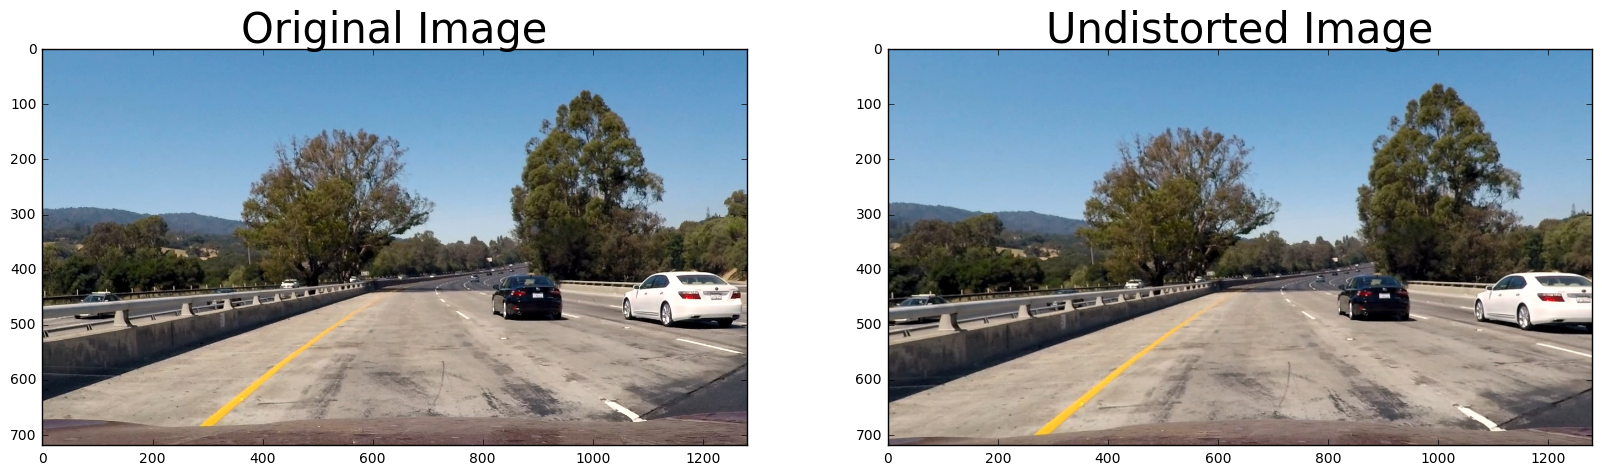

In [74]:
img = mpimg.imread(images[17])
dst = cv2.undistort(img, mtx, dist, None, mtx)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [348]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = cv2.undistort(img,mtx, dist, None, mtx)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    h_channel = hls[:,:,0]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = sx_thresh[0]
    thresh_max = sx_thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(s_binary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

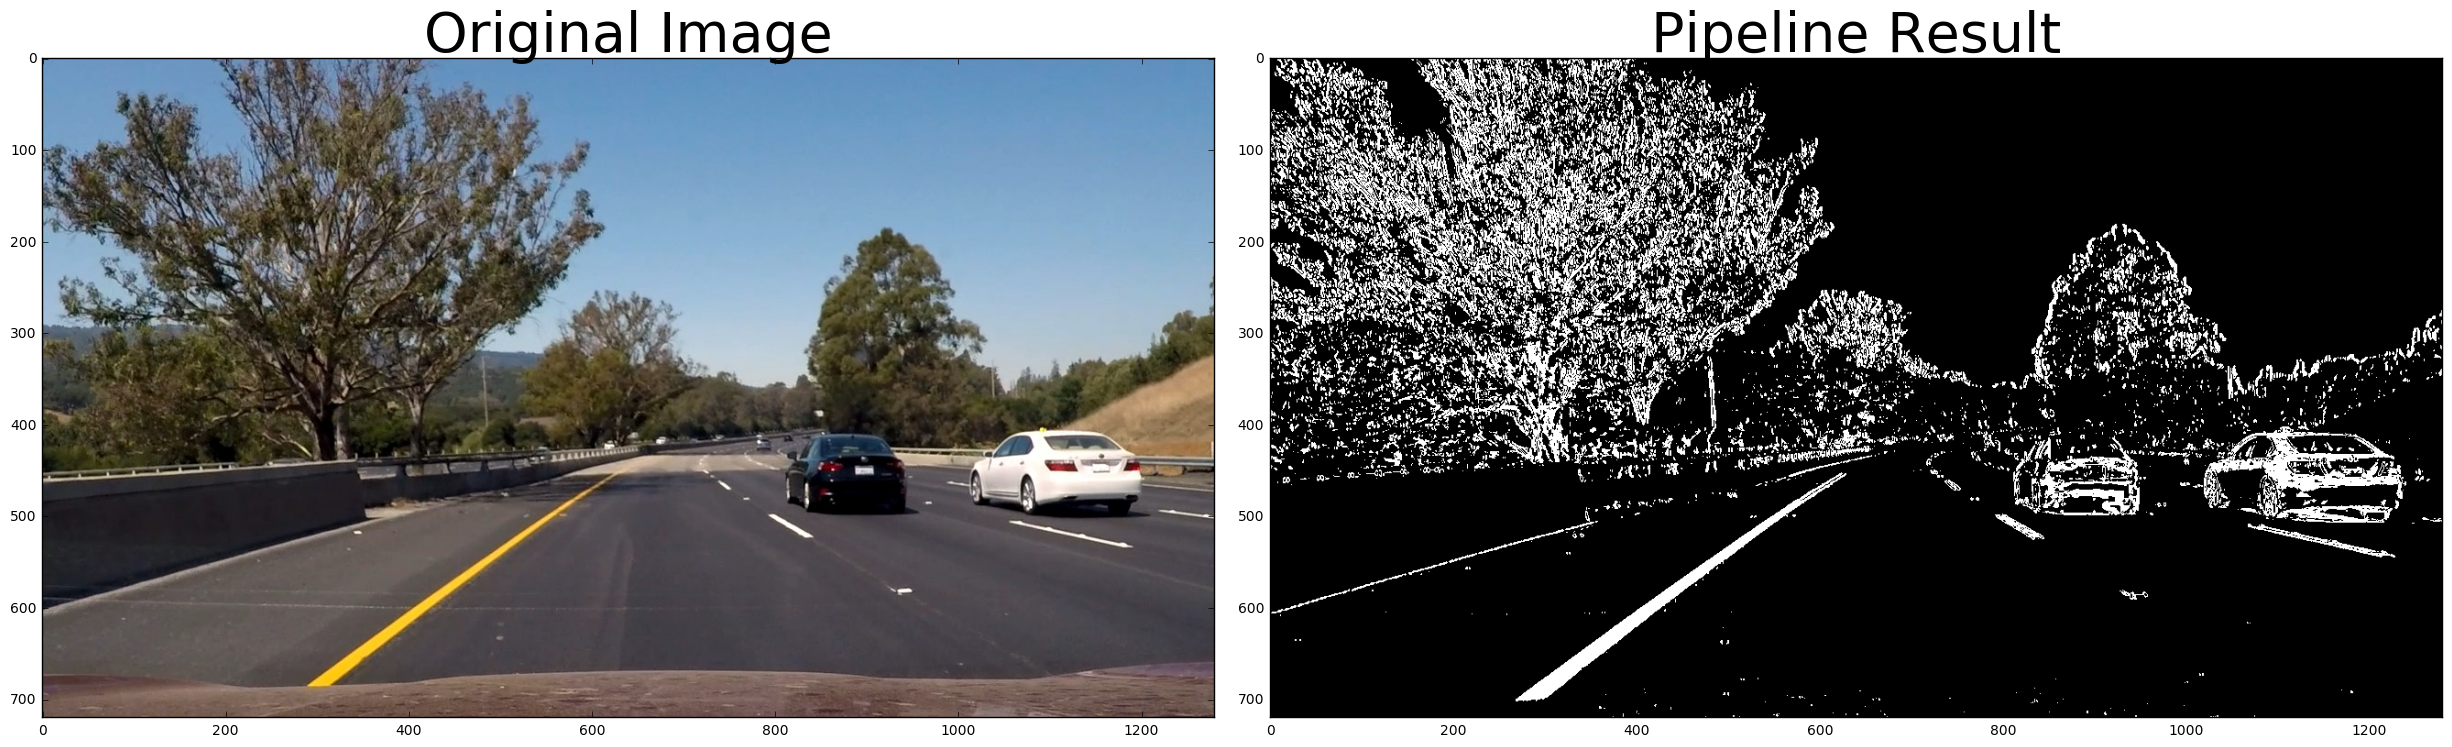

In [349]:
testimg = mpimg.imread("test_images/test6.jpg")
fin = pipeline(testimg)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(testimg)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(fin,cmap="gray")
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [335]:
def process_image(img):
    global part
    part = 0.8
    global lx1,lx2,lx3,lx4
    #reading in an image
    image = np.copy(img)
    imshape = image.shape
    
    imago = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    imago = cv2.GaussianBlur(img,(5,5),0) 
    
    lower_white = np.array([0, 0, 220])
    upper_white = np.array([200, 255, 255])



    hsv_bit = cv2.inRange(imago, lower_white, upper_white)
    
    edge = np.zeros_like(hsv_bit)
    mask_bit_value = 255
    mask = np.array([[(0,imshape[0]),(imshape[1]*0.53, imshape[0]/2), (imshape[1]*0.47, imshape[0]/2), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(edge,mask,mask_bit_value)
    
    hsv_bit = cv2.bitwise_and(hsv_bit,edge)
    row = 2
    theta = np.pi/90
    threshold = 55
    min_line_len = 40
    max_line_gap = 15

    lines = cv2.HoughLinesP(hsv_bit,row,theta,threshold,min_line_len,max_line_gap)

    if(lines==None):
        try:
            lines = [[[lx1,image.shape[0],lx2,image.shape[0]/1.5],[lx3,image.shape[0],lx4,image.shape[0]/1.5]]]
        except:
            return

    try:
        lx1
        xa = [lx1]
        xb = [lx2]
        xc = [lx3]
        xd = [lx4]
    except:
        xa = []
        xb = []
        xc = []
        xd = []
    ya = int(image.shape[0])
    yb = int(image.shape[0]/1.5)

    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)
            c = y2-(m*x2)
            if(-0.9<m<-0.5):
                xa.append(int((ya-c)/m))
                xb.append(int((yb-c)/m))

            elif(0.85>m>0.5):
                xc.append(int((ya-c)/m))
                xd.append(int((yb-c)/m))

    x1 = int(np.mean(xa))
    x2 = int(np.mean(xb))
    x3 = int(np.mean(xc))
    x4 = int(np.mean(xd))
    offset = int(image.shape[0]*0.1)
    offsety = int(image.shape[1]*0.1)
    try:
        lx1
        x1 = int(x1*(1-part) + lx1*part)
        x2 = int(x2*(1-part) + lx2*part)
        x3 = int(x3*(1-part) + lx3*part)
        x4 = int(x4*(1-part) + lx4*part)
        
    except:
        lx1=lx2=lx3=lx4=0
    cv2.line(image,(x1+offset,ya),(x2+offset,yb),(0,255,0),8)
    cv2.line(image,(x3+int(offset/2),ya),(x4+int(offset/2),yb),(0,255,0),8)
    lx1 = x1
    lx2 = x2
    lx3 = x3
    lx4 = x4
#     return np.int32([[(x1+x2)/2+offset,ya-offsety],[x2+offset,yb],[(x3+x4)/2+int(offset/2),ya-offsety],[x4+int(offset/2),yb]])
    m1 = (yb-ya)/(x2-x1)
    m2 = (yb-ya)/(x4-x3)
    x1 = 0
    x2 = (yb-ya)/m1 + x1
    x3 = img.shape[1]
    x4 = (yb-ya)/m2 + x3
    ya = int(img.shape[0]*0.90)
    print(m1)
    print(m2)
    return np.int32([[x1,ya],[x2,yb],[x3,ya],[x4,yb]])
    
#     return image

-0.6138107416879796
0.5660377358490566
[[   0  648]
 [ 391  480]
 [1280  648]
 [ 856  480]]
425


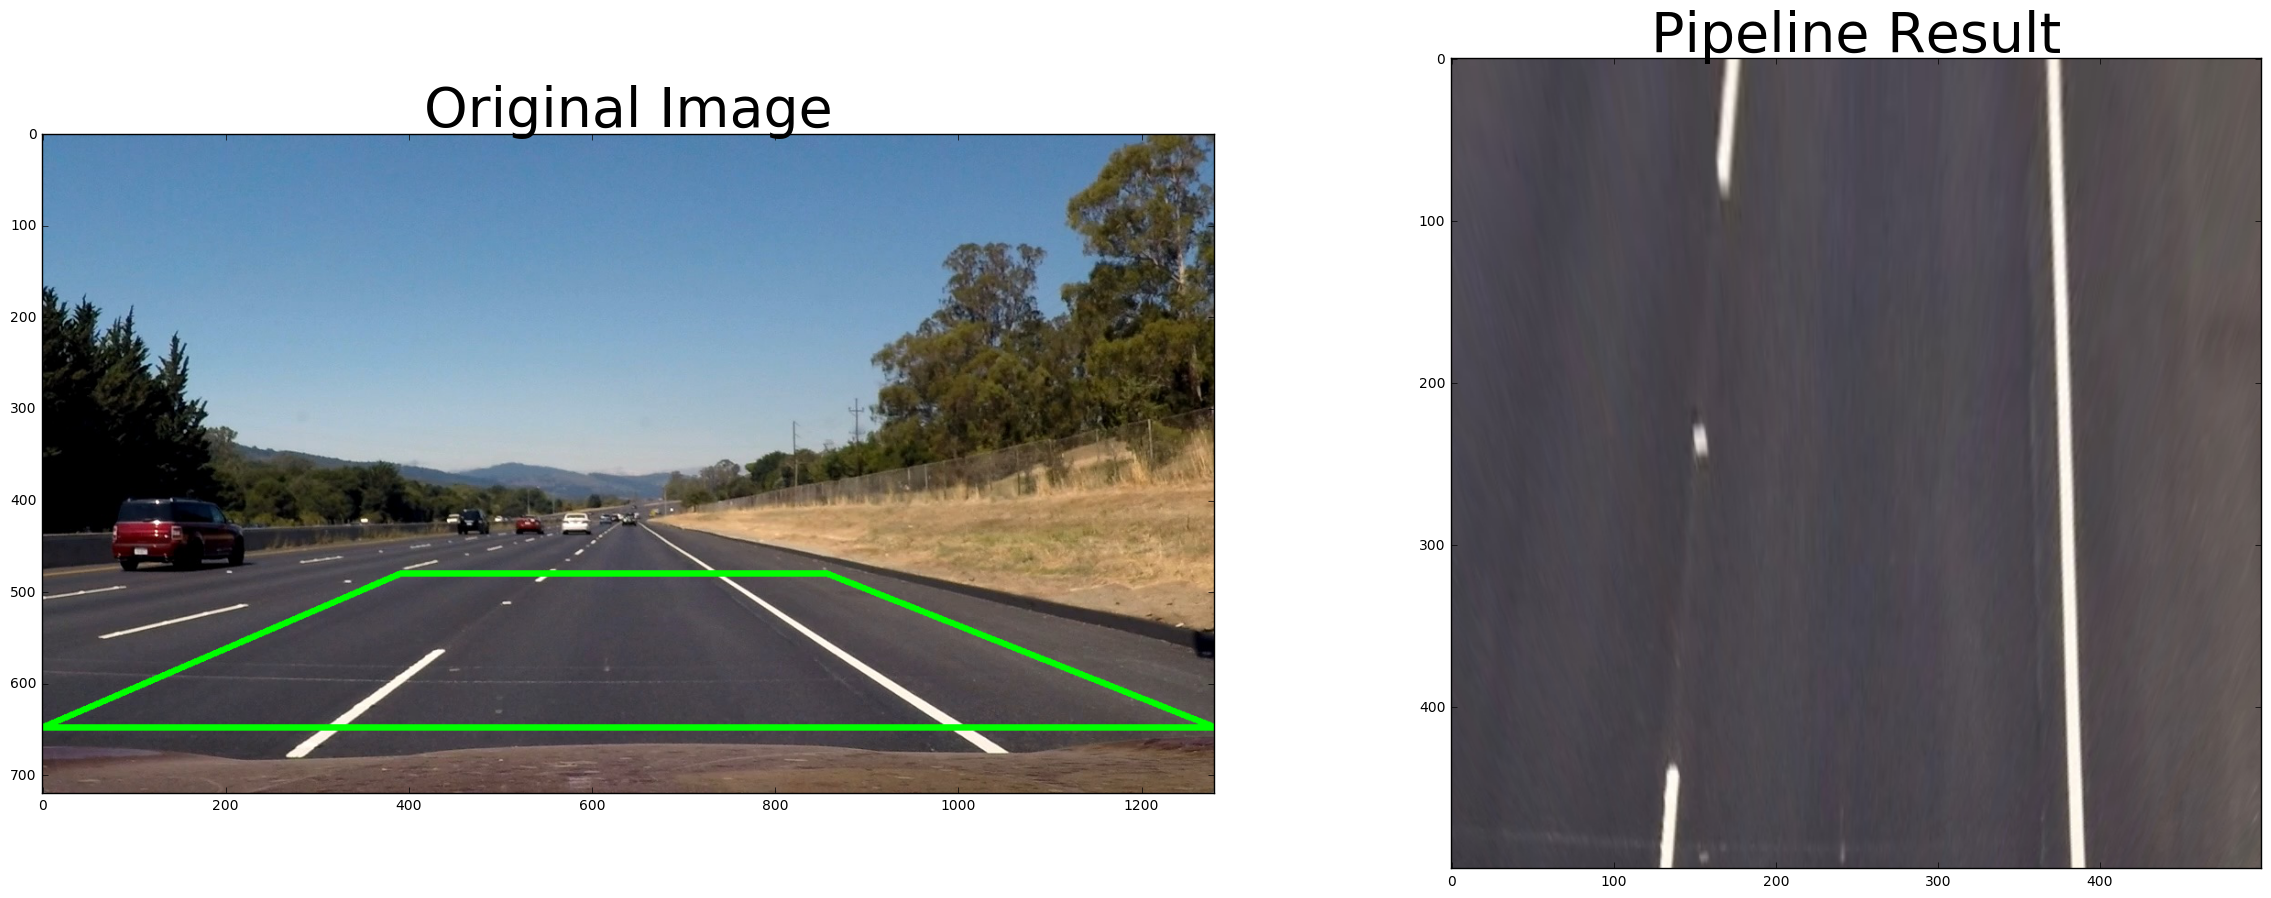

In [347]:
img = mpimg.imread("test_images/straight_lines2.jpg")
src = process_image(img)
# print(src)
# dst = np.float32([[src[0][0],src[0][1]],[src[0][0],src[1][1]],[src[2][0],src[2][1]],[src[2][0],src[3][1]]])
distance = int(math.pow(math.pow(src[0,0]-src[1,0],2)+math.pow(src[0,1]-src[1,1],2),1/2))
# print(distance)
# dst = np.float32([[0,src[0,1]],[0,src[0,1]-distance],[src[2,0],src[0,1]],[src[2,0],src[0,1]-distance]])
dst = np.float32([[0,0],[500,0],[0,600],[500,600]])
idx=[1,3,0,2]
M = cv2.getPerspectiveTransform(np.float32(src[idx]),dst)

final = cv2.warpPerspective(img,M,(500,500),flags=cv2.INTER_LINEAR)
idx=[0,1,3,2]
img = cv2.polylines(img,[src[idx].reshape((-1,1,2))],True,(0,255,0),6)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(final)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
img = mpimg.imread("test_images/straight_lines2.jpg")
